


# **Sentiment Analysis From Textual Data Using NLP**

# **`Dataset`**

In [5]:
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
nltk.download('wordnet')

# data from https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text?resource=download
data = pd.read_csv('tweet_emotion.csv')

data.head(4)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!


# **Dataset Analysis**

In [6]:
data.shape


(40000, 3)

In [7]:
data['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', nan,
       'surprise', 'love', 'fun', 'hate', 'happiness', 'boredom',
       'relief', 'anger'], dtype=object)

In [8]:
data.groupby('sentiment')['sentiment'].agg('count')

sentiment
anger          110
boredom        177
empty          814
enthusiasm     747
fun           1754
happiness     5145
hate          1302
love          3811
neutral       8503
relief        1507
sadness       5084
surprise      2154
worry         8343
Name: sentiment, dtype: int64

Droping tweet_id column

In [9]:
data=data.drop(['tweet_id'],axis='columns')
data.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


Checking if there is any empty values

In [10]:
data.isnull().sum()

sentiment    549
content        0
dtype: int64

Droping null values

In [11]:
data=data.dropna()
data.isnull().sum()

sentiment    0
content      0
dtype: int64

In [12]:
data.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


Encoding sentiment labels to numerical values

In [13]:
label_encoder = LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])
data.head()

,sentiment,content
0,2,@tiffanylue i know i was listenin to bad habi...
1,10,Layin n bed with a headache ughhhh...waitin o...
2,10,Funeral ceremony...gloomy friday...
3,3,wants to hang out with friends SOON!
4,8,@dannycastillo We want to trade with someone w...


Text preprocessing

In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(tokens)

data['content'] = data['content'].apply(preprocess_text)
data.head()

,sentiment,content
0,2,know listenin bad habit earlier started freaki...
1,10,layin n bed headache
2,10,funeral
3,3,want hang friend
4,8,want trade someone houston one


Balancing Dataset

In [15]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(data['content'].values.reshape(-1, 1), data['sentiment'])

Vectorize the text data using TF-IDF

In [16]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(X_resampled.ravel())
y = y_resampled


Spliting data into train and test sets. Here 80% is traing data and 20% is testing data.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 Initialize the classifiers with hyperparameter tuning

In [18]:
svm_classifier = SVC(kernel='linear', C=1)
rf_classifier = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
nb_classifier = MultinomialNB(alpha=0.1)

 Evaluating and poltting confusion matrix



In [19]:
def evaluate_and_plot_confusion_matrix(classifier, name):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {name}\nAccuracy: {accuracy:.2f}')
    plt.show()

 Evaluating the models

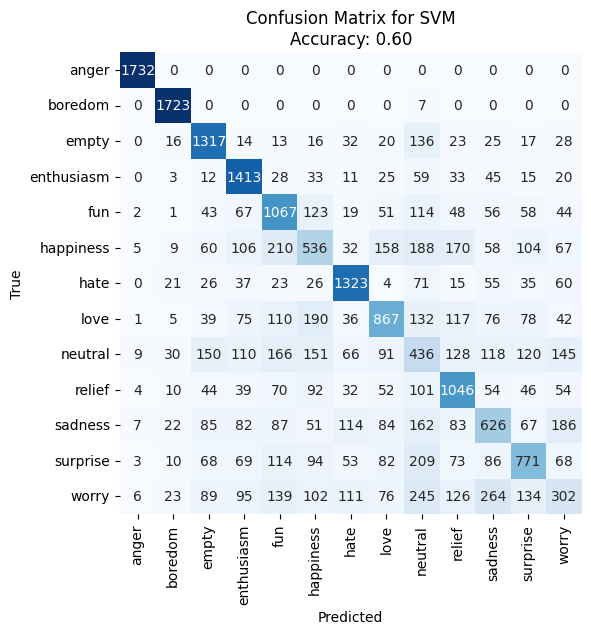

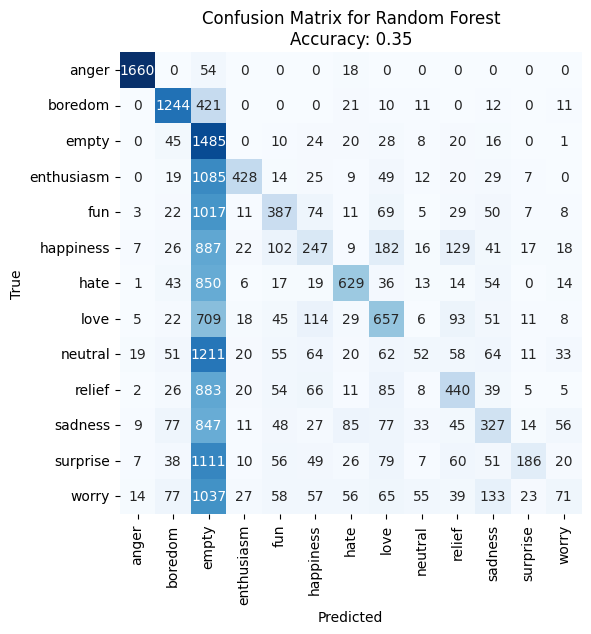

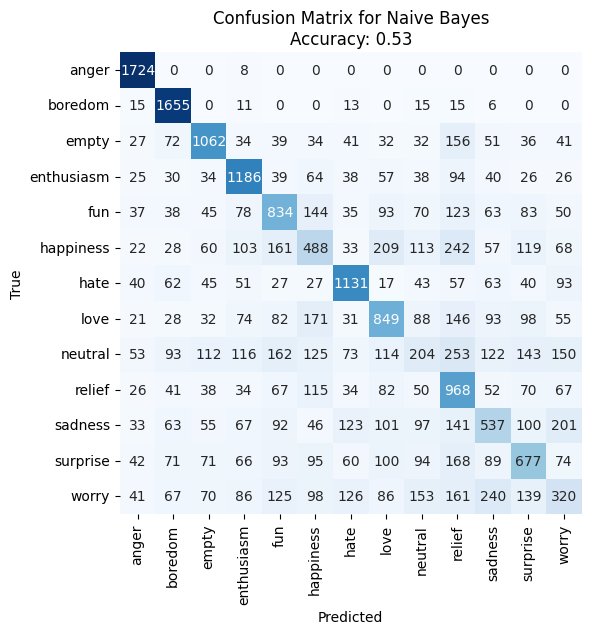

In [20]:
evaluate_and_plot_confusion_matrix(svm_classifier, "SVM")
evaluate_and_plot_confusion_matrix(rf_classifier, "Random Forest")
evaluate_and_plot_confusion_matrix(nb_classifier, "Naive Bayes")

In [23]:
example_text_data = [
    "I love this product. It's amazing!",
    "Terrible experience. I regret buying this.",
    "Neutral opinion about this. It's okay.",
    "The quality is excellent, but the price is too high.",
    "I love BRAC"
]
example_text_data = [preprocess_text(text) for text in example_text_data]

X_example_data = tfidf_vectorizer.transform(example_text_data)

svm_predictions = svm_classifier.predict(X_example_data)
rf_predictions = rf_classifier.predict(X_example_data)
nb_predictions = nb_classifier.predict(X_example_data)

predicted_sentiments_svm = label_encoder.inverse_transform(svm_predictions)
predicted_sentiments_rf = label_encoder.inverse_transform(rf_predictions)
predicted_sentiments_nb = label_encoder.inverse_transform(nb_predictions)

for i, text in enumerate(example_text_data):
    print(f"Text: {text}")
    print(f"SVM Predicted Sentiment: {predicted_sentiments_svm[i]}")
    print(f"Random Forest Predicted Sentiment: {predicted_sentiments_rf[i]}")
    print(f"Naive Bayes Predicted Sentiment: {predicted_sentiments_nb[i]}")
    print("="*30)


Text: love
SVM Predicted Sentiment: love
Random Forest Predicted Sentiment: love
Naive Bayes Predicted Sentiment: love
Text: terrible regret buying
SVM Predicted Sentiment: hate
Random Forest Predicted Sentiment: empty
Naive Bayes Predicted Sentiment: hate
Text: neutral opinion
SVM Predicted Sentiment: neutral
Random Forest Predicted Sentiment: empty
Naive Bayes Predicted Sentiment: relief
Text: quality price
SVM Predicted Sentiment: enthusiasm
Random Forest Predicted Sentiment: empty
Naive Bayes Predicted Sentiment: hate
Text: love brac
SVM Predicted Sentiment: love
Random Forest Predicted Sentiment: love
Naive Bayes Predicted Sentiment: love
